# Proyecto Series Temporales
### Grupo 8 - Walmart Sales
#### Integrantes:

- Diego Collado
- Iñigo González-Varas
- Carlota López
- Diego López



## 1. Introducción

TO-DO

Este trabajo trata de predecir las ventas semanales de Walmart.

## 2. Descripción y tratamiento de los datos

Importamos las librerías necesarias para el trabajo.

In [1]:
# Standard libraries
import warnings
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Statistical tools
import statsmodels.api as sm
from scipy import stats
from random import randint

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# skforecast imports
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster
from skforecast.utils import save_forecaster, load_forecaster

# Set visualization style
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Filter warnings
warnings.filterwarnings('ignore')

/Users/inogii/miniconda3/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Exploración preliminar de los datos

In [2]:
train_set = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

Train set: 5 columnas
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- Weekly_Sales: ventas semanales (date->date+7)
- IsHoliday: si la semana contiene un dia festivo

In [3]:
train_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Stores set: 3 columnas
- Store: número de tienda
- Type: tipo de tienda (se asigna una letra dependiendo del tamaño de la tienda)
- Size: tamaño de la tienda

In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Features set: 12 columnas
- Store: número de tienda
- Date: fecha de inicio de la semana
- Temperature: temperatura media durante la semana en la región donde está ubicada la tienda (Fahrenheit)
- Fuel_Price: precio medio del combustible en la zona donde está ubicada la tienda
- MarkDown1-5: datos anónimos relacionados con promociones. Esta información está disponible solo para algunas tiendas y para algunas fechas.
- CPI: índice de precios al consumo (Consumer Price Index). 
- Unemployment: tasa de desempleo
- IsHoliday: si la semana contiene un dia festivo


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Test set: 4 columnas (subconjunto de train)
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- IsHoliday: si la semana contiene un dia festivo


In [6]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### Conclusiones de la exploración preliminar

Con estos datos, vamos a tratar de predecir las ventas semanales de walmart agrupadas por tienda y departamento (ventas totales de walmart). 
En primer lugar, desarrollamos un modelo que únicamente tenga como input la serie temporal de ventas e intente prdecir las ventas futuras. 
Una vez veamos cómo funciona este modelo, añadiremos más variables (exógenas) del set de features para ver si podemos mejorar la predicción.

### Tratamiento de datos

En primer lugar, vamos a agrupar las ventas por tienda y departamento. Asignamos la fecha como índice del dataframe. De este modo obtenemos un dataframe con dos columnas: una con el índice (fecha) y otra con las ventas semanales.

In [7]:
total_sales = train_set.groupby('Date')['Weekly_Sales'].sum().reset_index()
total_sales['Date'] = pd.to_datetime(total_sales['Date'], format='%Y-%m-%d')
total_sales = total_sales.set_index('Date')
total_sales = total_sales.asfreq('W-FRI')

total_sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


In [8]:
def min_max_normalization(df, columns):
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = (df_copy[column] - df_copy[column].min()) / (df_copy[column].max() - df_copy[column].min())
    return df_copy

total_sales = min_max_normalization(total_sales, ['Weekly_Sales'])

Observamos la representación gráfica de la evolución de las ventas semanales de walmart agrupadas por tienda y departamento.

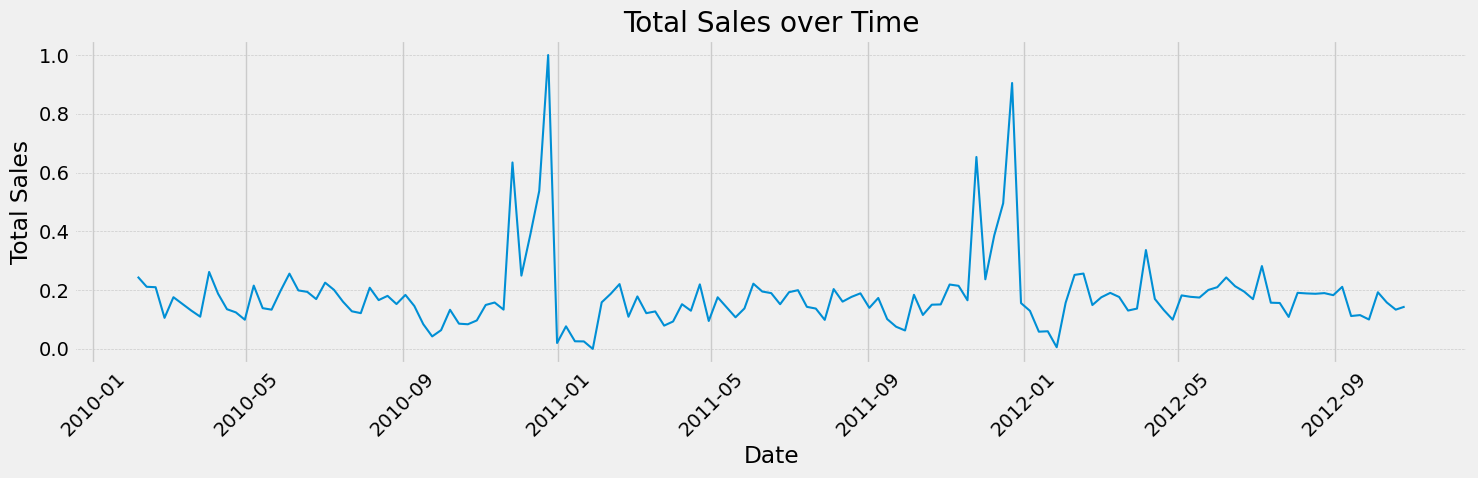

In [9]:
# Plotting the total sales over time
plt.figure(figsize=(15, 5))
plt.plot(total_sales.index, total_sales['Weekly_Sales'])
locator = mdates.MonthLocator()  
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales over Time')
plt.xticks(rotation=45)  # Rotate the x-ticks for better visibility
plt.tight_layout()  # Ensure layout is neat and no labels are cut off
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()

Vamos a dividir la serie en train y test. Para ello, vamos a coger el 85% de los datos para train y el 15% para test. Se puede ver la división claramente en la gráfica

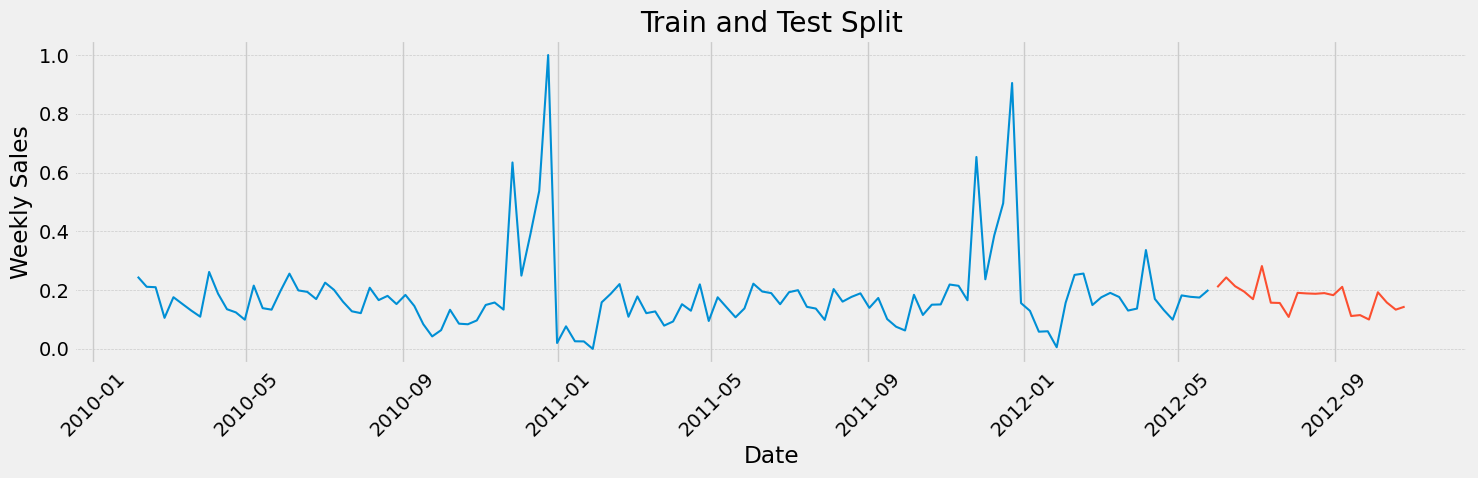

In [10]:
# splitting dataset into train and test set (80:20)
train, test = total_sales.iloc[:int(len(total_sales)*0.85)], total_sales.iloc[int(len(total_sales)*0.85):]
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Weekly_Sales'])
plt.plot(test.index, test['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Train and Test Split')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()


Definimos una función para crear los lags de la serie temporal. Así, tendremos un dataset que pueda servir como input de un modelo. Utilizamos un valor de 15 lags, ya que consideramos que es un valor adecuado para la predicción de series temporales semanales.
- Nota: en un primer momento pensamos que sería buena idea contar con los datos de las ventas de la misma semana del año anterior. Sin embargo, al contar con un número limitado de datos (solamente 3 años), muchos de los datos de la serie temporal se quedarían vacíos. Por ello, decidimos no incluir esta variable, aunque la función de obtención de lags soporte esta opción.

In [11]:
def create_lag_features(df, lag_columns, max_lag, max_yearly_lag=0):
    temp_df = df.copy()
    
    # Create weekly lag features
    for column in lag_columns:
        for lag in range(1, max_lag + 1):
            temp_df[f'{column}_lag_{lag}'] = temp_df[column].shift(lag)
    
    # Create yearly lag features for same week of previous years and the weeks before that
    for column in lag_columns:
        for year in range(1, max_yearly_lag + 1):
            for lag in range(0, max_lag):  # Starting from 0 to capture the same week from the previous year
                temp_df[f'{column}_year{year}_lag_{lag}'] = temp_df[column].shift(52 * year + lag)
                
    return temp_df

def split_train_test(df, train_size):
    train, test = df.iloc[:int(len(df)*train_size)], df.iloc[int(len(df)*train_size):]
    test.dropna(inplace=True)  # Drop the rows with missing values in the test set
    train.dropna(inplace=True)
    return train, test

train_size = 0.85
df = create_lag_features(total_sales, ['Weekly_Sales'], 15, max_yearly_lag=0)  # Adjust the parameters as needed
train, test = split_train_test(df, train_size)
train.head()


,Weekly_Sales,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_3,Weekly_Sales_lag_4,Weekly_Sales_lag_5,Weekly_Sales_lag_6,Weekly_Sales_lag_7,Weekly_Sales_lag_8,Weekly_Sales_lag_9,Weekly_Sales_lag_10,Weekly_Sales_lag_11,Weekly_Sales_lag_12,Weekly_Sales_lag_13,Weekly_Sales_lag_14,Weekly_Sales_lag_15
Date,,,,,,,,,,,,,,,,
2010-05-21,0.133560,0.138640,0.215414,0.099325,0.124230,0.135098,0.187882,0.261882,0.109701,0.130388,0.153044,0.175934,0.105699,0.209940,0.211384,0.245597
2010-05-28,0.197371,0.133560,0.138640,0.215414,0.099325,0.124230,0.135098,0.187882,0.261882,0.109701,0.130388,0.153044,0.175934,0.105699,0.209940,0.211384
2010-06-04,0.256189,0.197371,0.133560,0.138640,0.215414,0.099325,0.124230,0.135098,0.187882,0.261882,0.109701,0.130388,0.153044,0.175934,0.105699,0.209940
2010-06-11,0.199041,0.256189,0.197371,0.133560,0.138640,0.215414,0.099325,0.124230,0.135098,0.187882,0.261882,0.109701,0.130388,0.153044,0.175934,0.105699
2010-06-18,0.194094,0.199041,0.256189,0.197371,0.133560,0.138640,0.215414,0.099325,0.124230,0.135098,0.187882,0.261882,0.109701,0.130388,0.153044,0.175934


## Entrenamiento del modelo

El primer modelo que vamos a entrenar es un Decision Tree Regressor, ya que fue el primer modelo utilizado en clase. Dividimos nuestros datos en de train y test en datos de entrada (X) y datos de salida (y). Definimos el modelo, lo entrenamos y hacemos la predicción.

### Decision Tree Regressor

In [12]:
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']
X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=10, random_state=42)
modelo_arbol.fit(X_train, y_train)
predicciones_tree = modelo_arbol.predict(X_test)
err_tree = mean_squared_error(y_test, predicciones_tree)
print(err_tree)

0.003677796640699699


Una vez predicho, comparamos los resultados con los datos de test. Para ello, creamos una gráfica con los datos de test y los datos predichos por el modelo.

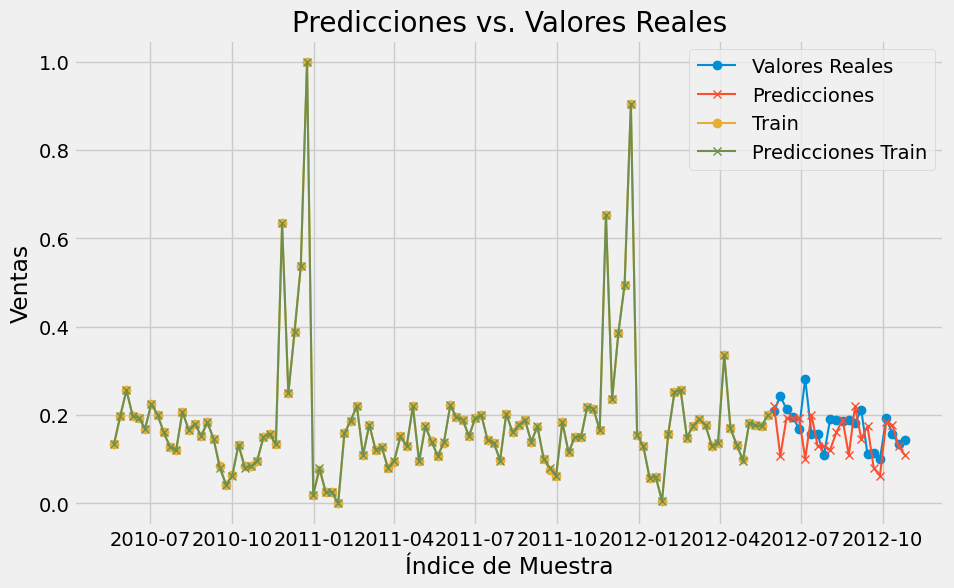

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index,y_test, label='Valores Reales', marker='o')
plt.plot(y_test.index,predicciones_tree, label='Predicciones', marker='x')
plt.plot(y_train.index,y_train, label='Train', marker='o')
plt.plot(y_train.index,modelo_arbol.predict(X_train), label='Predicciones Train', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')
plt.legend()
plt.show()

### Forecaster

El segundo modelo que vamos a entrenar es un Forecaster de skforecast que utilice regresión lineal y 15 lags. Después de entrenarlo, hacemos la predicción y comparamos los resultados con los datos de test.

In [14]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=train['Weekly_Sales'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = len(y_test)
               )
predicciones = predicciones.set_index(y_test.index)

err_forecast = mean_squared_error(y_test, predicciones['pred'])
if err_forecast > err_tree:
    print("El error del DecisionTree es menor que el error del Forecast con regresión lineal")
else: 
     print("El error del DecisionTree es mayor que el error del Forecast con regresión lineal")
print(f'Err Tree: {err_tree} Err Forecast: {err_forecast}')
print(f'Ratio (err_forecast/err_tree) : {err_forecast/err_tree}')

El error del DecisionTree es mayor que el error del Forecast con regresión lineal
Err Tree: 0.003677796640699699 Err Forecast: 0.0022007493726693807
Ratio (err_forecast/err_tree) : 0.5983879990304981


Hacemos una gráfica con los valores reales y los predichos, así como los intervalos de confianza.

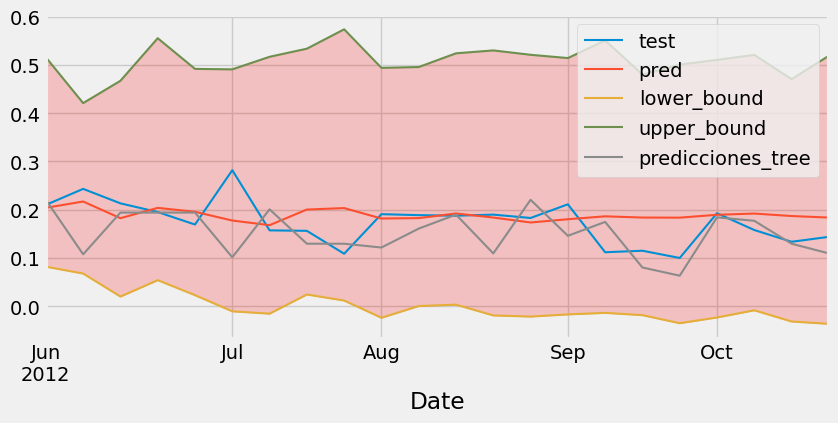

In [15]:
fig, ax = plt.subplots(figsize=(9, 4))
y_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
predicciones_tree = pd.Series(predicciones_tree, index=y_test.index)
predicciones_tree.plot(ax=ax, label='predicciones_tree')
ax.fill_between(
    y_test.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

Vemos que tanto las predicciones de Decision Tree Regressor como las de Forecaster son similares, ambas dentro del intervalo de confianza. 

# Experimento 2

Una vez vistos los dos primeros modelos más básicos, vamos a tratar de crear modelos más complejos que puedan mejorar la predicción.

## Random Forest Regressor

In [16]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags = 15
             )

forecaster.fit(y=train['Weekly_Sales'])
forecaster
# Intervalos de predicción
# ==============================================================================


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-05-21 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-07 17:34:32 
Last fit date: 2023-10-07 17:34:32 
Skforec

In [17]:
predicciones = forecaster.predict(
                    steps    = len(y_test)
               )

predicciones.head(5)



2012-06-01    0.186140
2012-06-08    0.169927
2012-06-15    0.137983
2012-06-22    0.120106
2012-06-29    0.126666
Freq: W-FRI, Name: pred, dtype: float64

In [18]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')


Err Forecast: 0.0023090365777088413


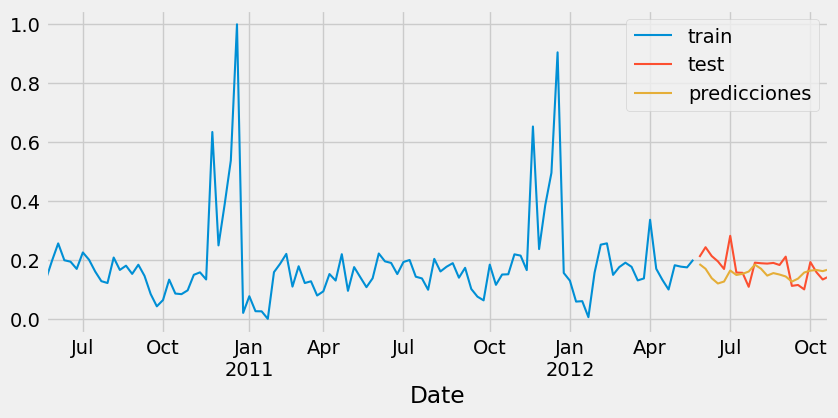

In [19]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

Con la configuracion base comprobamos que el resultado mejora por lo que vamos a hacer un gridsearch a ver si lo mejoramos aun más

## RANDOM FOREST GRID

In [20]:
steps = len(y_test)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20, 40]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_estimators': [20, 50, 100, 200],
              'max_depth': [50, 100, 200, 500]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Weekly_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 48.


lags grid: 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 50, 'n_estimators': 20}
  Backtesting metric: 0.012357562299708615



In [21]:
predicciones = forecaster.predict(steps=len(y_test))

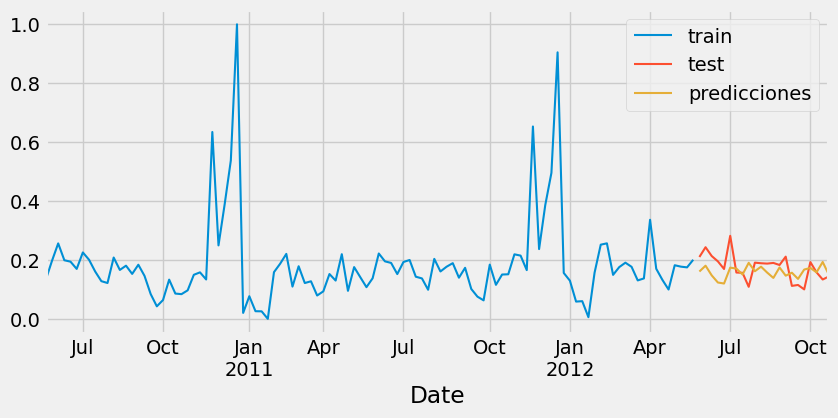

In [22]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [23]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 0.0025669573469252072


Los resultados son mejores vamos a porbar con KNN y lasso, perimero sin grid search, veremos cual de los dos es mejor y haremos un grid con el mejor para ver si los resultados son mejores

## KNN BASICO

In [24]:

forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(),
                lags = 6
             )

forecaster.fit(y=train['Weekly_Sales']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: KNeighborsRegressor() 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-05-21 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} 
fit_kwargs: {} 
Creation date: 2023-10-07 17:34:49 
Last fit date: 2023-10-07 17:34:49 
Skforecast version: 0.10.1 
Python version: 3.11.2 
Forecaster id: None 

In [25]:
predicciones = forecaster.predict(steps=len(y_test))

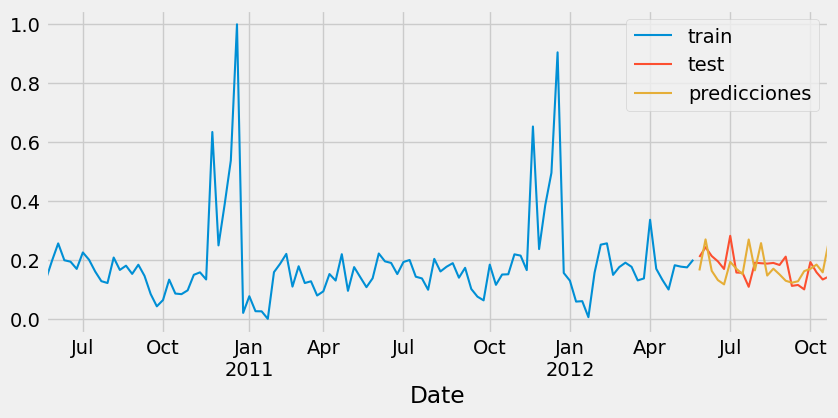

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [27]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 0.0037028046763786936


Vamos a probar con el lasso

## LASSO BASICO

In [28]:
from sklearn import linear_model
forecaster = ForecasterAutoreg(                
                regressor = linear_model.Lasso(alpha=0.1),
                lags = 6
             )

forecaster.fit(y=train['Weekly_Sales']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: Lasso(alpha=0.1) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-05-21 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-07 17:34:49 
Last fit date: 2023-10-07 17:34:49 
Skforecast version: 0.10.1 
Python version: 3.11.2 
Forecaster id: None 

In [29]:
predicciones = forecaster.predict(steps=len(y_test))

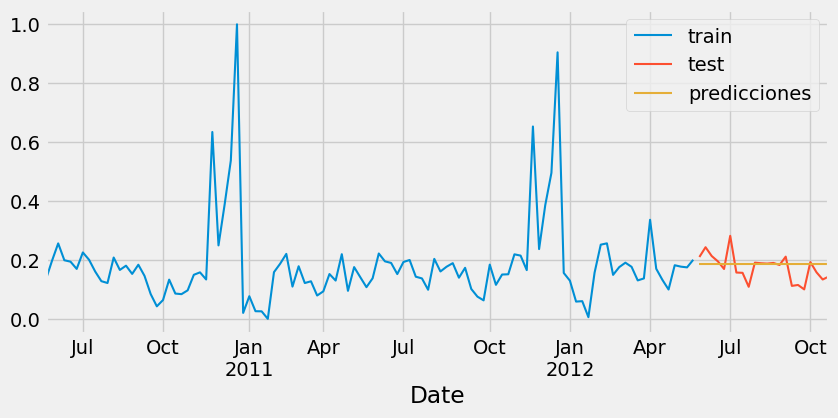

In [30]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [31]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 0.0020593768299385687


El modelo lasso es el que mejor se adapta a la tendencia pero no predice los picos demasiado bien, vamos a hacer un gridsearch a ver si mejora

## LASSO GRID

In [32]:
steps = len(y_test)
forecaster = ForecasterAutoreg(
                regressor = linear_model.Lasso(alpha=0.1),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 10, 20, 40]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'max_iter': [500, 1000, 2000, 5000],
              'alpha':[0.005, 0.007, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.024, 0.025, 0.026, 0.03],
              
              }

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Weekly_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 192.


lags grid: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'alpha': 0.005, 'max_iter': 500}
  Backtesting metric: 0.020565293733220157



In [33]:
predicciones = forecaster.predict(steps=len(y_test))

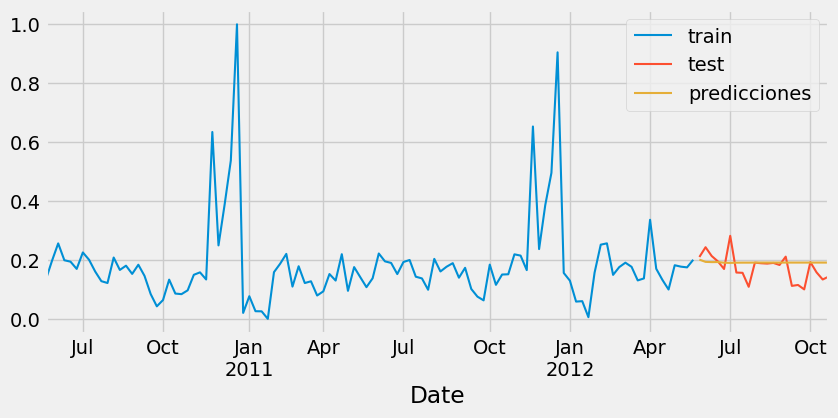

In [34]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [35]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 0.002197775467447293


## KNN GRID

In [36]:
steps = len(y_test)
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 10, 20]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              'weights': ['uniform', 'distance'],
              
              }

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Weekly_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 90.


lags grid: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'n_neighbors': 6, 'weights': 'distance'}
  Backtesting metric: 0.02048818272258678



In [37]:
predicciones = forecaster.predict(steps=len(y_test))

Err Forecast: 0.005489923687524229


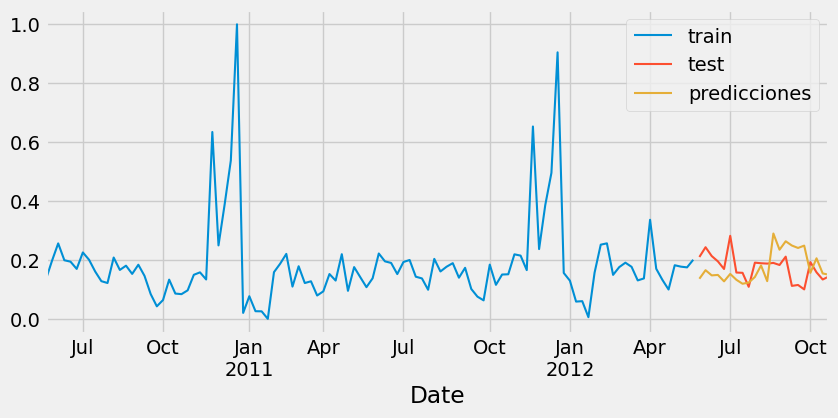

In [38]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

## BACKTESTING

In [39]:
steps = len(y_test)
n_backtesting = steps  

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = total_sales['Weekly_Sales'],
                                    initial_train_size = len(total_sales) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 121
Number of observations used for backtesting: 22
    Number of folds: 1
    Number of steps per fold: 22
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-02-05 00:00:00 -- 2012-05-25 00:00:00  (n=121)
    Validation: 2012-06-01 00:00:00 -- 2012-10-26 00:00:00  (n=22)



100%|██████████| 1/1 [00:00<00:00, 1303.79it/s]

Error de backtest: 0.006634551898829299


Err Forecast: 0.006634551898829299


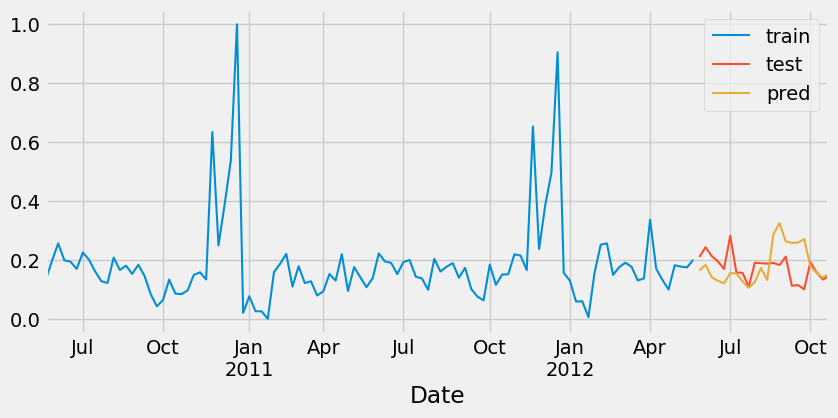

In [40]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
err_forecast = mean_squared_error(y_test, predicciones_backtest)

print(f'Err Forecast: {err_forecast}')
ax.legend();


# Experimento 3: Modelos con variables exógenas

En primer lugar vamos a añadir las variables exógenas de la tabla features. Para ello, vamos a unir los datos de ventas semanales con los datos de features. 

In [41]:
# unimos los sets originales de train_set y features
df = train_set.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
# limpiamos las columnas duplicadas o aquellas que no contienen información relevante
df.drop(['IsHoliday_y'], axis=1,inplace=True) 
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
df.loc[df['Weekly_Sales']<=0]
df = df.loc[df['Weekly_Sales'] > 0]
df = df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Size','Type'], axis=1)

df_agrupado = df.groupby('Date').agg({'Weekly_Sales': 'sum'}).reset_index()
df_agrupado = df_agrupado.merge(df.drop('Weekly_Sales', axis=1), on=['Date'], how='inner')
df_agrupado.drop('Dept', axis=1, inplace=True)
df_agrupado.drop('Store', axis=1, inplace=True)

df_sin_duplicados = df_agrupado.drop_duplicates(subset=['Weekly_Sales'])
df_sin_duplicados =df_sin_duplicados.reset_index(drop=  True)

df_sin_duplicados['Date'] = pd.to_datetime(df_sin_duplicados['Date'], format='%Y-%m-%d')
df_sin_duplicados = df_sin_duplicados.set_index('Date')
df_sin_duplicados = df_sin_duplicados.asfreq('W-FRI')

In [42]:
dfexog = df_sin_duplicados.copy()
dfexog['IsHoliday'] = dfexog['IsHoliday'].astype(int)
dfexog = min_max_normalization(dfexog, ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
dfexog.head()

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,49750875.98,0,0.122844,0.041637,0.057904,1.0
2010-02-12,48336800.10,1,0.055289,0.024408,0.069028,1.0
2010-02-19,48277902.33,0,0.080533,0.000000,0.072612,1.0
2010-02-26,43970440.65,0,0.199644,0.033740,0.074939,1.0
2010-03-05,46872715.16,0,0.197333,0.079684,0.077266,1.0


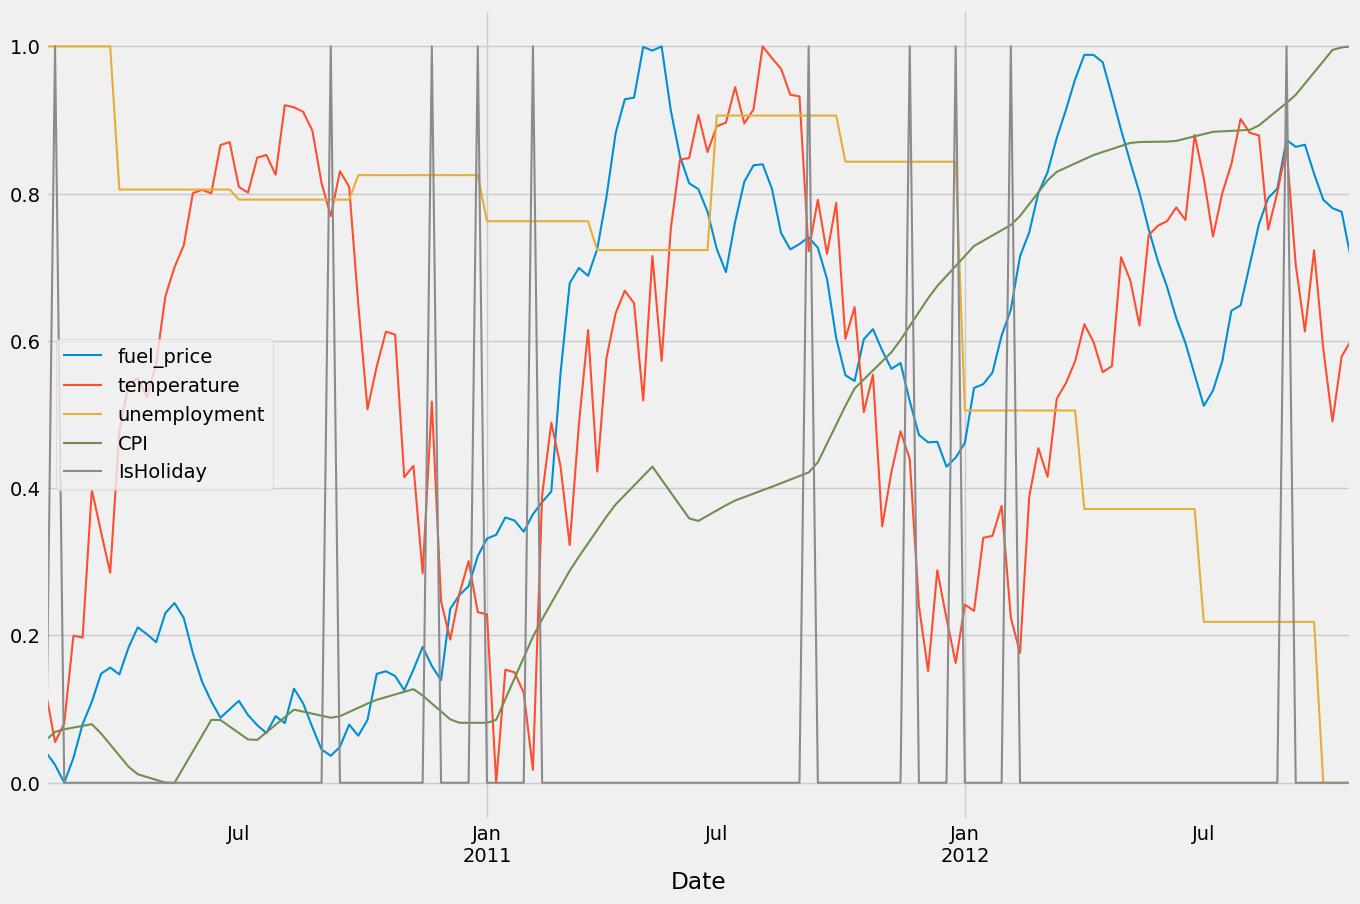

In [43]:
fig, ax = plt.subplots(figsize=(15, 10))
dfexog['Fuel_Price'].plot(ax=ax, label='fuel_price')
dfexog['Temperature'].plot(ax=ax, label='temperature')
dfexog['Unemployment'].plot(ax=ax, label='unemployment')
dfexog['CPI'].plot(ax=ax, label='CPI')
dfexog['IsHoliday'].plot(ax=ax, label='IsHoliday')
ax.legend();

In [44]:
steps = len(y_test)
datos_train = dfexog[:-steps]
datos_test  = dfexog[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2010-02-05 00:00:00 --- 2012-05-25 00:00:00  (n=121)
Fechas test  : 2012-06-01 00:00:00 --- 2012-10-26 00:00:00  (n=22)


### Búsqueda del mejor modelo

In [45]:
regressors = [
    LinearRegression,
    Lasso,
    DecisionTreeRegressor,
    RandomForestRegressor,
    KNeighborsRegressor,
]

best_regressors = []

# Placeholder for param_grid, lags_grid, and steps. Please provide appropriate values
param_grid = {
    LinearRegression: {
        'fit_intercept': [True, False],
    },
    Lasso: {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
    },
    DecisionTreeRegressor: {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    KNeighborsRegressor: {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
}

lags_grid = list(range(1, 40))

steps = len(datos_test)

for regressor in regressors:
    
        forecaster = ForecasterAutoreg(
            regressor=regressor(),
            lags = lags_grid[0]
        )
        
        current_param_grid = param_grid[regressor]

        resultados_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=datos_train['Weekly_Sales'],
            exog=datos_train.drop(columns='Weekly_Sales'),
            param_grid=current_param_grid,
            lags_grid=lags_grid,
            steps=steps,
            refit=True,
            metric='mean_squared_error',
            initial_train_size=int(len(datos_train) * 0.5),
            fixed_train_size=False,
            return_best=True,
            verbose=False
        )

        # Fit using the best parameters from the grid search
        best_forecaster = forecaster
        
        predicciones = best_forecaster.predict(steps=len(datos_test), exog=datos_test.drop(columns='Weekly_Sales'))
        err = mean_squared_error(datos_test['Weekly_Sales'], predicciones)
        
        best_regressors.append({
            'forecaster': best_forecaster,
            'regressor': regressor,
            'lags': resultados_grid['lags'],
            'err': err
        })

Number of models compared: 78.


lags grid: 100%|██████████| 39/39 [00:01<00:00, 31.23it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'fit_intercept': True}
  Backtesting metric: 39857127956659.96

Number of models compared: 468.


lags grid: 100%|██████████| 39/39 [00:09<00:00,  4.20it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'alpha': 100, 'fit_intercept': True}
  Backtesting metric: 39711486230747.19

Number of models compared: 2106.


lags grid: 100%|██████████| 39/39 [01:01<00:00,  1.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
  Backtesting metric: 8972769472374.332

Number of models compared: 16848.


lags grid:  92%|█████████▏| 36/39 [39:06<03:22, 67.62s/it]

In [1]:
best_regressors = pd.DataFrame(best_regressors)
best_regressors.sort_values('err')

fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(15, 5*5))

for i, row in best_regressors.iterrows():
    #predict and plot predictions
    predicciones = row['forecaster'].predict(steps=len(datos_test), exog=datos_test.drop(columns='Weekly_Sales'))
    err_mse = mean_squared_error(datos_test['Weekly_Sales'], predicciones)
    err_mape = mean_absolute_percentage_error(datos_test['Weekly_Sales'], predicciones)
    err_mae = mean_absolute_error(datos_test['Weekly_Sales'], predicciones)

    print(f'ERR MSE: {err_mse:.4f}')
    print(f'ERR MAPE: {err_mape * 100:.4f}% de error medio sobre las ventas semanales')
    print(f'ERR MAE: {err_mae:.4f} ventas semanales de error medio')

    ax[i].plot(datos_test.index, datos_test['Weekly_Sales'], label='test')
    ax[i].plot(datos_test.index, predicciones, label='predicciones')
    ax[i].set_title(row['regressor'].__name__)
    ax[i].legend();

NameError: name 'pd' is not defined

In [ ]:
best_regressors = []

param_grid = {
    Lasso: {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
    }
}

for regressor in regressors:
    
        forecaster = ForecasterAutoreg(
            regressor=regressor(),
            lags = lags_grid[0]
        )
        
        current_param_grid = param_grid[regressor]

        resultados_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=datos_train['Weekly_Sales'],
            exog=datos_train['Temperature'],
            param_grid=current_param_grid,
            lags_grid=lags_grid,
            steps=steps,
            refit=True,
            metric='mean_squared_error',
            initial_train_size=int(len(datos_train) * 0.5),
            fixed_train_size=False,
            return_best=True,
            verbose=False
        )

        # Fit using the best parameters from the grid search
        best_forecaster = forecaster
        
        predicciones = best_forecaster.predict(steps=len(datos_test), exog=datos_test.drop(columns='Weekly_Sales'))
        err = mean_squared_error(datos_test['Weekly_Sales'], predicciones)
        
        best_regressors.append({
            'forecaster': best_forecaster,
            'regressor': regressor,
            'lags': resultados_grid['lags'],
            'err': err
        })


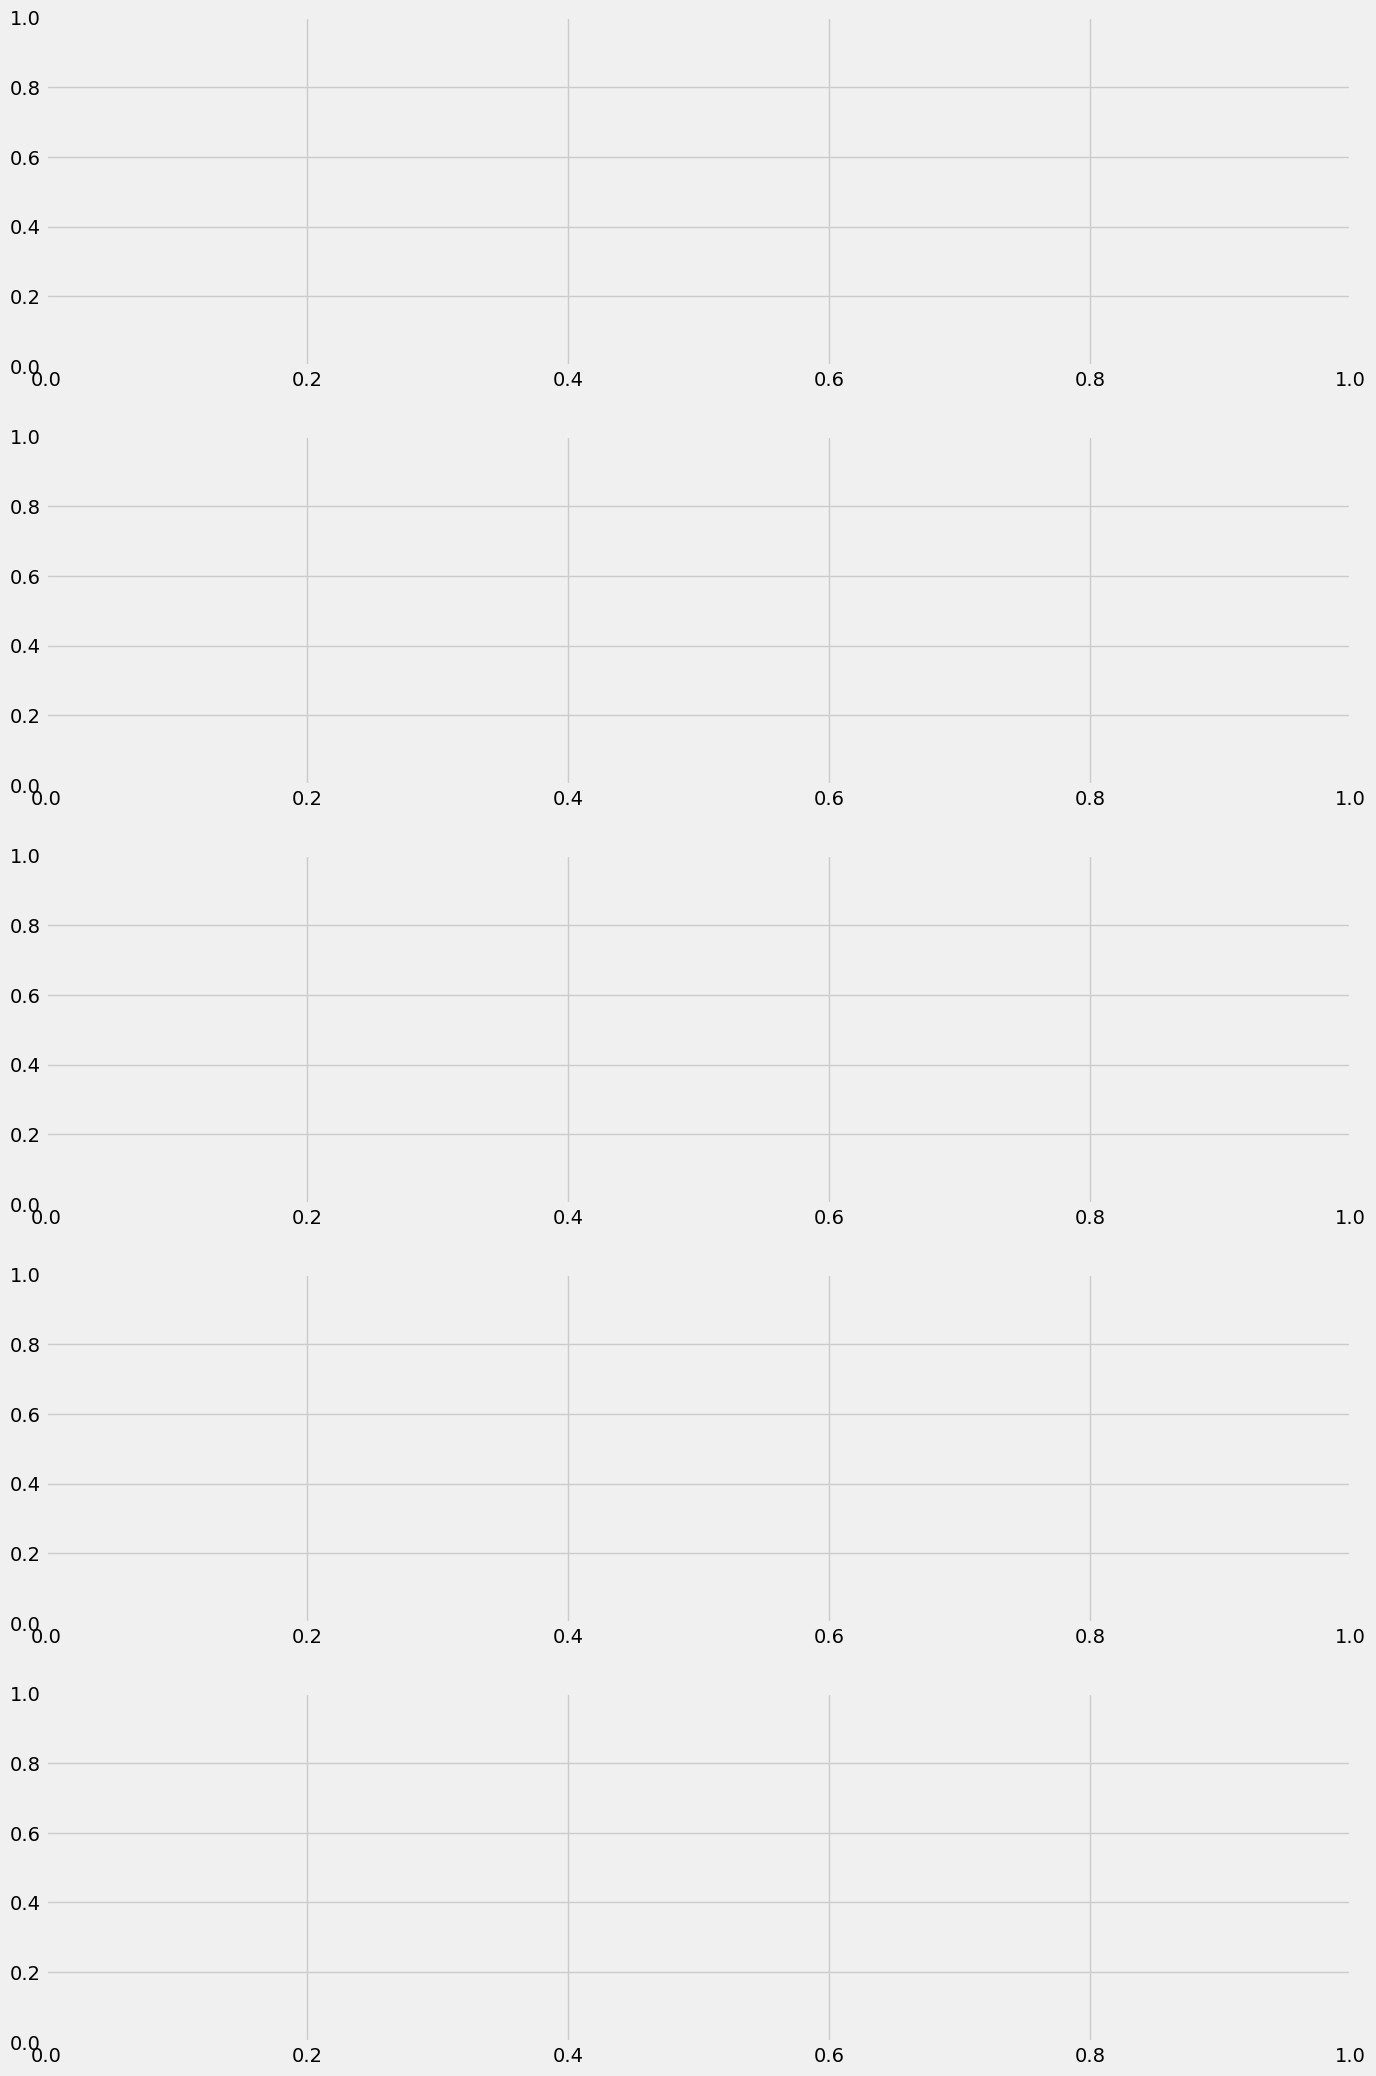

In [ ]:
best_regressors = pd.DataFrame(best_regressors)

fig, ax = plt.subplots(ncols=1, nrows=5, figsize=(15, 5*5))

for i, row in best_regressors.iterrows():
    #predict and plot predictions
    predicciones = row['forecaster'].predict(steps=len(datos_test), exog=datos_test.drop(columns='Weekly_Sales'))
    err_mse = mean_squared_error(datos_test['Weekly_Sales'], predicciones)
    err_mape = mean_absolute_percentage_error(datos_test['Weekly_Sales'], predicciones)
    err_mae = mean_absolute_error(datos_test['Weekly_Sales'], predicciones)

    print(f'ERR MSE: {err_mse:.4f}')
    print(f'ERR MAPE: {err_mape * 100:.4f}% de error medio sobre las ventas semanales')
    print(f'ERR MAE: {err_mae:.4f} ventas semanales de error medio')

    ax[i].plot(datos_test.index, datos_test['Weekly_Sales'], label='test')
    ax[i].plot(datos_test.index, predicciones, label='predicciones')
    ax[i].set_title(row['regressor'].__name__)
    ax[i].legend();